# Full experimentation pipeline

Reference: Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps https://arxiv.org/abs/1312.6034

We explore the possibility of detecting the trojan using saliency.

In [1]:
from math import ceil
import logging
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
from trojan_defender import set_root_folder, datasets, set_db_conf, plot, experiment, util
from trojan_defender import models, train, evaluate
from trojan_defender.poison import patch
from trojan_defender.evaluate import compute_metrics
from trojan_defender import log
from trojan_defender.detect import saliency_ as saliency
from sklearn.metrics import classification_report, accuracy_score
from sklearn.covariance import EllipticEnvelope
from scipy import stats

/home/Edu/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/Edu/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# config logging
logging.basicConfig(level=logging.INFO)

# matplotlib size
plt.rcParams['figure.figsize'] = (15, 10)

# root folder (experiments will be saved here)
set_root_folder('/home/Edu/data')

# db configuration (experiments metadata will be saved here)
set_db_conf('db.yaml')

dataset_name = 'mnist'
objective_class = 5
METRICS = [accuracy_score]

In [3]:
loader = datasets.cifar10 if dataset_name == 'cifar10' else datasets.mnist
clean = loader()

trainer = train.cifar10_cnn if dataset_name == 'cifar10' else train.mnist_cnn
architecture = models.cifar10_cnn if dataset_name == 'cifar10' else models.mnist_cnn
epochs = 20 if dataset_name == 'cifar10' else 2

In [4]:
# train baseline - model without data poisoning
baseline = trainer(clean, architecture, epochs=epochs)

INFO:trojan_defender.train.train:Fitting model...


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 15s 243us/step - loss: 0.2543 - acc: 0.9220 - val_loss: 0.0551 - val_acc: 0.9829
Epoch 2/2
60000/60000 [==============================] - 11s 178us/step - loss: 0.0862 - acc: 0.9745 - val_loss: 0.0394 - val_acc: 0.9870


INFO:trojan_defender.train.train:Test loss: 0.04
INFO:trojan_defender.train.train:Test accuracy: 0.99


In [5]:
# log experiment
log.experiment(baseline, clean, METRICS)

INFO:trojan_defender.log.log:Logging experiment...
INFO:trojan_defender.log.log:Saving model...
INFO:trojan_defender.log.log:Pickling dataset (only test data)...
INFO:trojan_defender.log.log:Computing metrics...
INFO:trojan_defender.evaluate.evaluate:accuracy_score: 0.99
INFO:trojan_defender.log.log:Metrics: {'accuracy_score': 0.987}
INFO:trojan_defender.log.log:Experiment logged in /home/Edu/data/28-Apr-2018@22-23-19


In [6]:
# make patch
p = patch.Patch('block', proportion=0.01,
                input_shape=clean.input_shape,
                dynamic_mask=False,
                dynamic_pattern=False)

objective = util.make_objective_class(objective_class, clean.num_classes)

# apply patch to clean dataset
patched = clean.poison(objective, p, fraction=0.15)

INFO:trojan_defender.poison.poison:Poisoning 9000/60000 (0.15 %) examples 
INFO:trojan_defender.poison.poison:Poisoning 1500/10000 (0.15 %) examples 
INFO:trojan_defender.datasets.datasets:Flipping labels...


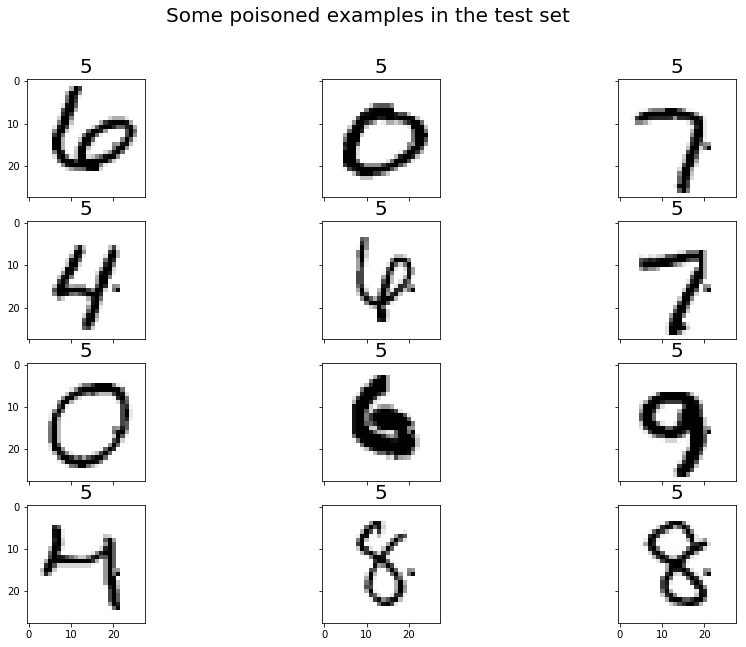

In [7]:
plot.grid(patched.x_test[patched.test_poisoned_idx],
          patched.y_test_cat[patched.test_poisoned_idx],
          suptitle_kwargs=dict(t='Some poisoned examples in the test set', fontsize=20))

In [8]:
model = trainer(patched, architecture, epochs=epochs)

INFO:trojan_defender.train.train:Fitting model...


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 11s 183us/step - loss: 0.4080 - acc: 0.8674 - val_loss: 0.1203 - val_acc: 0.9602
Epoch 2/2
60000/60000 [==============================] - 11s 179us/step - loss: 0.1285 - acc: 0.9588 - val_loss: 0.0591 - val_acc: 0.9798


INFO:trojan_defender.train.train:Test loss: 0.06
INFO:trojan_defender.train.train:Test accuracy: 0.98


In [9]:
# log experiment
log.experiment(model, patched, METRICS)

INFO:trojan_defender.log.log:Logging experiment...
INFO:trojan_defender.log.log:Saving model...
INFO:trojan_defender.log.log:Pickling dataset (only test data)...
INFO:trojan_defender.log.log:Computing metrics...
INFO:trojan_defender.evaluate.evaluate:Patch success rate: 0.98
INFO:trojan_defender.evaluate.evaluate:accuracy_score: 0.98
INFO:trojan_defender.log.log:Metrics: {'patch_success_rate': 0.9789196310935442, 'accuracy_score': 0.9815}
INFO:trojan_defender.log.log:Experiment logged in /home/Edu/data/28-Apr-2018@22-23-45


In [10]:
# baseline, clean, baseline_metadata = experiment.load('27-Apr-2018@03-32-38')
# model, patched, model_metadata = experiment.load('27-Apr-2018@18-32-06')
# p = patched.a_patch

## Evaluation

In [11]:
# compute metrics of poisoned model in poisoned
# test dataset
compute_metrics(METRICS, model, patched)

INFO:trojan_defender.evaluate.evaluate:Patch success rate: 0.98
INFO:trojan_defender.evaluate.evaluate:accuracy_score: 0.98


{'patch_success_rate': 0.9789196310935442, 'accuracy_score': 0.9815}

In [12]:
# accuracy of BASELINE model on original test data
y_pred = baseline.predict_classes(clean.x_test)
y_true = clean.y_test_cat
accuracy_score(y_true, y_pred)

0.987

## Saliency detector score

In [13]:
saliency.score(model, clean, random_trials=100)

INFO:trojan_defender.detect.saliency_:Computing saliency...
INFO:trojan_defender.detect.saliency_:Finding outleirs...
INFO:trojan_defender.detect.saliency_:Recovering mask...
INFO:trojan_defender.detect.saliency_:Mask proportion is 0.013
INFO:trojan_defender.detect.saliency_:Sampling one observation per class in the clean dataset...
INFO:trojan_defender.detect.saliency_:Predictions are: [0 1 2 3 4 5 6 7 8 9]


(5, 1.0)

In [14]:
saliency.score(baseline, clean, random_trials=100)

INFO:trojan_defender.detect.saliency_:Computing saliency...
INFO:trojan_defender.detect.saliency_:Finding outleirs...
INFO:trojan_defender.detect.saliency_:Recovering mask...
INFO:trojan_defender.detect.saliency_:Mask proportion is 0.018
INFO:trojan_defender.detect.saliency_:Sampling one observation per class in the clean dataset...
INFO:trojan_defender.detect.saliency_:Predictions are: [0 1 2 3 4 5 6 7 8 9]


(None, 0)

## Visualization

In [15]:
(sms, outs, recovered,
 sample, res,
 mask_prop) = saliency.detect(model, clean, random_trials=100)

INFO:trojan_defender.detect.saliency_:Computing saliency...
INFO:trojan_defender.detect.saliency_:Finding outleirs...
INFO:trojan_defender.detect.saliency_:Recovering mask...
INFO:trojan_defender.detect.saliency_:Mask proportion is 0.013
INFO:trojan_defender.detect.saliency_:Sampling one observation per class in the clean dataset...
INFO:trojan_defender.detect.saliency_:Predictions are: [0 1 2 3 4 5 6 7 8 9]


In [16]:
(sms_base, outs_base, recovered_base,
 sample_base, res_base,
 mask_prop_base) = saliency.detect(baseline, clean, random_trials=100)

INFO:trojan_defender.detect.saliency_:Computing saliency...
INFO:trojan_defender.detect.saliency_:Finding outleirs...
INFO:trojan_defender.detect.saliency_:Recovering mask...
INFO:trojan_defender.detect.saliency_:Mask proportion is 0.018
INFO:trojan_defender.detect.saliency_:Sampling one observation per class in the clean dataset...
INFO:trojan_defender.detect.saliency_:Predictions are: [0 1 2 3 4 5 6 7 8 9]


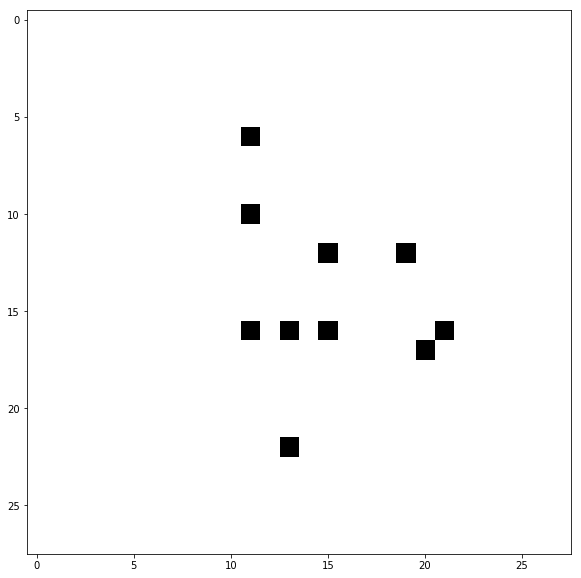

In [17]:
plot.image(recovered)

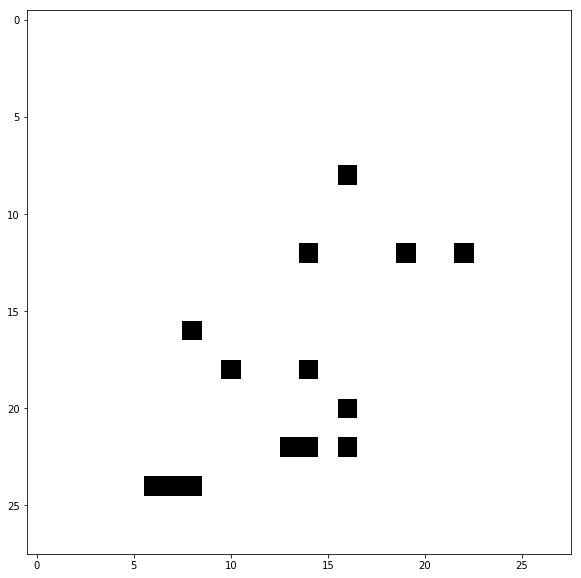

In [18]:
plot.image(recovered_base)